## Imports

In [1]:
import numpy as np
import tensorflow as tf
from sklearn import model_selection
import matplotlib.pyplot as plt
import cPickle

## Read Data

In [13]:
def unpickle( file ):
    fo = open(file, 'rb')
    data_dict = cPickle.load(fo)
    fo.close()
    return data_dict
 
data = unpickle( 'cifar-10-batches-py/data_batch_1' )

features = data['data']
labels = data['labels']
labels = np.atleast_2d( labels ).T

# whiten our data - zero mean and unit standard deviation
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
features = features.reshape(10000, 3, 32, 32).transpose(0,2,3,1)

train_features, test_features, train_labels, test_labels = model_selection.train_test_split(features, labels, test_size=0.2)

## Helper Functions

In [42]:
def conv( x, filter_size=3, stride=2, num_filters=64, is_output=False, name="conv" ):
    '''
    x is an input tensor
    Declare a name scope using the "name" parameter
    Within that scope:
      Create a W filter variable with the proper size
      Create a B bias variable with the proper size
      Convolve x with W by calling the tf.nn.conv2d function
      Add the bias
      If is_output is False,
        Call the tf.nn.relu function
      Return the final op
    ''' 
    filter_height, filter_width = filter_size, filter_size
    in_channels = x.get_shape().as_list()[-1]
    out_channels = num_filters
    
    with tf.variable_scope(name) as scope:
        W = tf.get_variable("{}_W".format(name), shape=[filter_height, filter_width, in_channels, out_channels], initializer = tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable("{}_b".format(name), shape=[out_channels], initializer = tf.contrib.layers.variance_scaling_initializer())
        conv = tf.nn.conv2d(x, W, [1, stride, stride, 1], padding="SAME")
        out = tf.nn.bias_add(conv, b)
        
        if not is_output:
            out = tf.nn.relu(out)
            
    return out


def fc( x, out_size=50, is_output=False, name="fc" ):
    '''
    x is an input tensor
    Declare a name scope using the "name" parameter
    Within that scope:
      Create a W filter variable with the proper size
      Create a B bias variable with the proper size
      Multiply x by W and add b
      If is_output is False,
        Call the tf.nn.relu function
      Return the final op
    '''
    in_size = x.get_shape().as_list()[0]
    
    with tf.variable_scope(name) as scope:
        W = tf.get_variable("{}_W".format(name), shape=[out_size, in_size], initializer = tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable("{}_b".format(name), shape=[out_size, 1], initializer = tf.contrib.layers.variance_scaling_initializer())
        
        out = tf.matmul(W, x)
        out = out + b
        
        if not is_output:
            out = tf.nn.relu(out)
    return out

## Network

In [46]:
tf.reset_default_graph()

input_data = tf.placeholder(tf.float32, [1,32,32,3])
y_true = tf.placeholder(tf.int64, None)

h0 = conv(input_data, stride=1, name="h0") #[1, 32, 32, 64]
h1 = conv(h0, stride=2, name="h1") #[1, 16, 16, 64]
h2 = conv(h1, num_filters=32, name="h2") #[1, 8, 8, 32]
flat = tf.reshape(h2, [1*8*8*32, 1]) #[1*8*8*32,1]
# fc0 = fc(flat, name="fc0") #[50,1]
logits= fc(flat, out_size = 10, is_output=True, name="output") # [10,1]


with tf.name_scope( "loss_function" ) as scope:
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=tf.transpose(logits), labels=y_true)[0]

with tf.name_scope( "accuracy" ) as scope:
    correct_prediction = tf.equal( y_true, tf.argmax(logits,0) )
    accuracy = tf.reduce_mean( tf.cast(correct_prediction, tf.float32) )

train_step = tf.train.AdamOptimizer( 0.001 ).minimize( cross_entropy )

## Training

In [47]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

train_writer = tf.summary.FileWriter( "./tflogs", sess.graph )
 
tf.summary.scalar('cross_entropy', cross_entropy)
tf.summary.scalar('accuracy', accuracy)
merged = tf.summary.merge_all()

tmp_loss = 0.0
accuracy_li = []
loss_li = []
for i in range( 100000 ):
    ind_train = np.random.randint(len(train_features))

    image_train = train_features[ind_train]
    label_train = train_labels[ind_train]

    acc_test = 0
    
    _, loss = sess.run( [train_step, cross_entropy], feed_dict={input_data: image_train.reshape([1,32,32,3]), y_true: label_train})
    tmp_loss += loss
    
    if i % 1000 == 0 and i != 0:
        for k in range(len(test_features)):
            acc_test += sess.run( accuracy, feed_dict={input_data: test_features[k].reshape([1,32,32,3]), y_true: test_labels[k]})

    if i % 1000 == 0 and i != 0:
        print( "i:{} test_acc:{} loss:{}".format( i, acc_test/len(test_features), tmp_loss ) )
        accuracy_li.append(acc_test/len(test_features))
        loss_li.append(tmp_loss)
        tmp_loss = 0.0

#saver.save( sess, './tf_logs/model.ckpt' )
train_writer.close()

i:1000 test_acc:0.141 loss:2865.93112846
i:2000 test_acc:0.137 loss:2319.2063337
i:3000 test_acc:0.123 loss:2270.76796405
i:4000 test_acc:0.1785 loss:2243.73290451
i:5000 test_acc:0.163 loss:2271.64539111
i:6000 test_acc:0.1715 loss:2232.14169329
i:7000 test_acc:0.174 loss:2215.08135256
i:8000 test_acc:0.1595 loss:2274.92620832
i:9000 test_acc:0.166 loss:2207.40084359
i:10000 test_acc:0.175 loss:2206.86724478
i:11000 test_acc:0.1795 loss:2186.13196889
i:12000 test_acc:0.1905 loss:2145.4332892
i:13000 test_acc:0.2005 loss:2136.81069869
i:14000 test_acc:0.1985 loss:2126.31443018
i:15000 test_acc:0.2025 loss:2148.02753508
i:16000 test_acc:0.206 loss:2122.64745647
i:17000 test_acc:0.1895 loss:2106.88966116
i:18000 test_acc:0.214 loss:2106.29772225
i:19000 test_acc:0.218 loss:2043.81404559
i:20000 test_acc:0.224 loss:2105.77881038
i:21000 test_acc:0.221 loss:2050.32843131
i:22000 test_acc:0.22 loss:2040.08417091
i:23000 test_acc:0.2225 loss:2079.75197935
i:24000 test_acc:0.233 loss:2040.325

## Plots

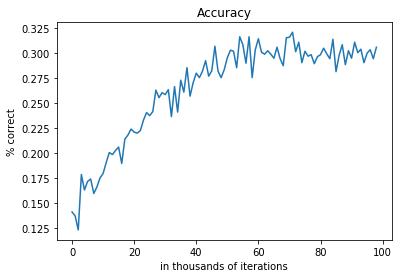

In [49]:
plt.plot(accuracy_li)
plt.title("Accuracy")
plt.xlabel("in thousands of iterations")
plt.ylabel("% correct")
plt.show()

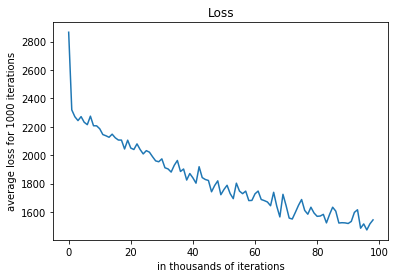

In [50]:
plt.plot(loss_li)
plt.title("Loss")
plt.xlabel("in thousands of iterations")
plt.ylabel("average loss for 1000 iterations")
plt.show()

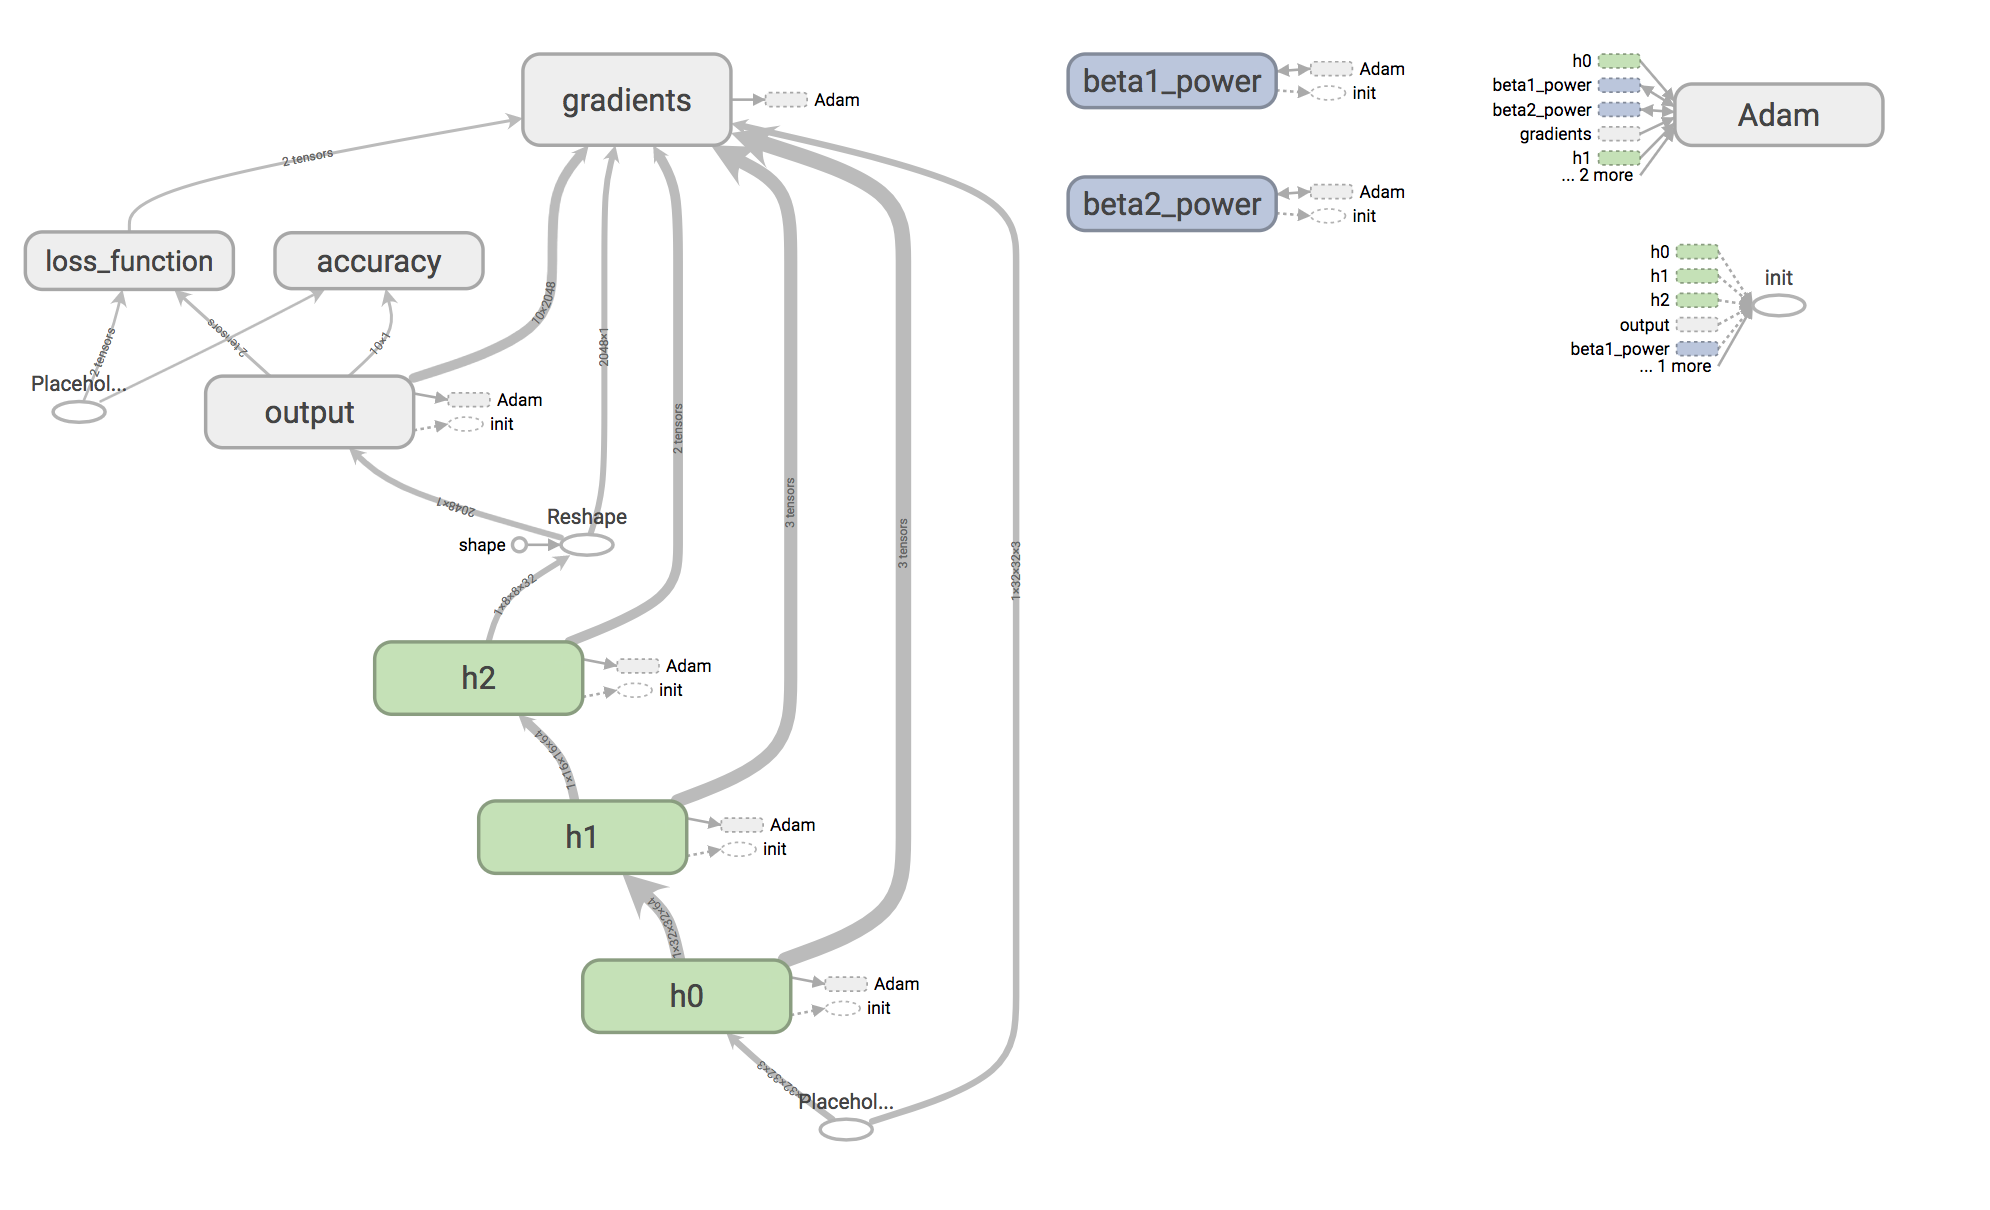

In [51]:
from IPython.display import Image
Image("graph1.png")